In [2]:
%%capture
!pip install plotly pandas numpy matplotlib seaborn
!pip install ipympl itables

# Common code and variables

In [142]:
%matplotlib widget

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib as mpl
# Use the pgf backend (must be set before pyplot imported)
# mpl.use('pgf')
from matplotlib import pyplot as plt, ticker

import seaborn as sns
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)

plt.style.use('seaborn')

width = 800

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family":  "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 17,
    "font.size": 9,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

<IPython.core.display.Javascript object>

In [12]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    elif width == 'acm':
        width_pt = 506.295
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 + 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in / golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [382]:
databases = { 'ClickhouseDB': '#1d6195',
             'ClickHouse': '#1d6195',
              'InfluxDB': '#75BDA7', 
              'TimescaleDB': '#c78181', 
              'PostgresDB':'orange',
            'PostgreSQL':'orange'}
labels = { 'ClickhouseDB': 'ClickHouse',
              'InfluxDB': 'InfluxDB', 
          'PostgresDB':'PostgreSQL',    
          'TimescaleDB': 'TimescaleDB', 
              }
color_discrete_map_extra = { 'ClickhouseDB': 'grey', 
                            'InfluxDB': '#c78181', 
                            'TimescaleDB': 'grey', 
                            'InfluxDBEnhanced' : '#1d6195' }

legend_kwargs = dict(borderpad=0.5, frameon=True, framealpha=1, facecolor='white', edgecolor='#F5F5F5', ncol=2, title=None)

In [343]:
## System Metrics Helpers
def to_megabytes(x):
    return x / 1e6

def to_mbps(x):
    return x * 8 / 1e6

def used_mem(x):
    l =  x * 100 / 32e9
    return l

def plot_database(ax, data, key, func, x=None, label=None):
    if func == 'log':
        ax.set_yscale('log')
    elif callable(func):
        data = func(data)
    if x is None:
        x = pd.Series(range(len(data)))
    return ax.plot(x, data, label=label, color=databases[key])

# Ingestion Scenarios

## Scaling

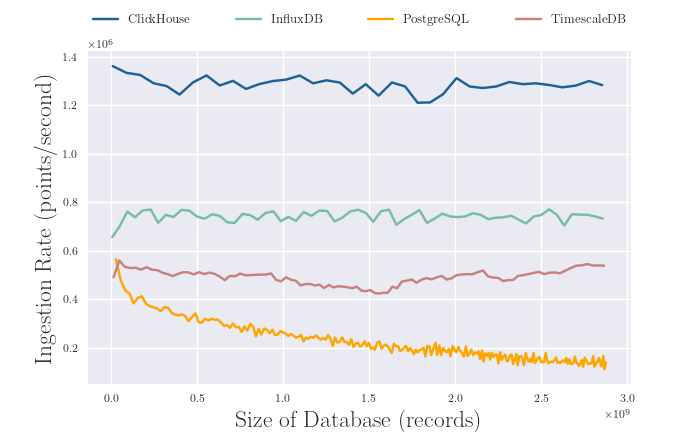

Loading... (need help?)


In [202]:
results = pd.read_csv('../Results/Scaling 48c-20000b-100000s/Metrics.csv',)
results['Date'] = pd.to_datetime(results['Date'], unit='ns')
results  = results.sort_values(by=['TargetDatabase', 'Date'])

def ingestion_rate(group):
    dates = group.index
    min_date = dates.min()
    max_date = dates.max()
    all_values = group['SucceededDataPoints'].sum()
    time = (max_date - min_date).total_seconds()
    return pd.Series({ 'IngestionRate': all_values / time, 'Total': all_values })

def to_string(x):
    return int(x.seconds // 60)

database_groups = results.set_index('Date').groupby('TargetDatabase')
ingestion_rates = database_groups.resample('1min').apply(ingestion_rate).reset_index()
for name, group in ingestion_rates.groupby('TargetDatabase'):
    count = group['TargetDatabase'].count()
    min_date = group['Date'].min()
    duration_index = (ingestion_rates[ingestion_rates["TargetDatabase"] == name]["Date"] - min_date).transform(to_string)
    values_index = ingestion_rates[ingestion_rates["TargetDatabase"] == name]["Total"].cumsum()
    ingestion_rates.loc[ingestion_rates['TargetDatabase'] == name, 'Duration'] = duration_index
    ingestion_rates.loc[ingestion_rates['TargetDatabase'] == name, 'Size'] = values_index
    
#show(ingestion_rates)
fig, ax = plt.subplots(figsize=set_size('acm',))
for key, grp in ingestion_rates.groupby(['TargetDatabase']):
    ax.plot(grp['Size'][:-1], grp['IngestionRate'][:-1], label=labels[key], color=databases[key])

ymin, ymax = ax.get_ylim()
# ax.set_ylim(ymin, ymax * 1.35)
ax.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0., prop={'size': 9}) 

ax.set_xlabel('Size of Database (records)')
ax.set_ylabel('Ingestion Rate (points/second)')
# plt.tight_layout()
plt.show()
plt.savefig('/home/jalal/papers/phd/tsdb/vldb/figures/scaling.pdf', format='pdf')

summary = []
for key, grp in database_groups:
    grp_summary = {}
    grp_summary['TargetDatabase'] = key
    grp_summary['TotalTime'] = grp.index.max() - grp.index.min()
    grp_summary['TotalIngestionRate'] = grp['SucceededDataPoints'].sum() / grp_summary['TotalTime'].total_seconds()
    grp_summary['MBps'] = grp_summary['TotalIngestionRate'] * 24 / 1e6
    summary.append(grp_summary)

show(pd.DataFrame(data=summary))
    

Loaded 23274 Items in 0:00:00.120024
Index(['Timestamp', 'Database', 'Operation', 'ClientsNumber', 'BatchSize',
       'SensorsNumber', 'CpuTotal', 'CpuSystem', 'CpuUser', 'CpuIOWait',
       'CpuContextSwitches', 'CpuSysCalls', 'MemActive', 'MemAvailable',
       'MemBuffers', 'MemCached', 'MemFree', 'MemInActive', 'MemTotal',
       'MemShared', 'MemUsed', 'SwapFree', 'SwapSin', 'SwapSout', 'SwapTotal',
       'SwapUsed', 'DiskReadBytes', 'DiskReadCount', 'DiskWriteBytes',
       'DiskWriteCount', 'NetworkCumulativeConnections',
       'NetworkCumulativeReceives', 'NetworkCumulativeTransmissions',
       'NetworkConnections', 'NetworkTransmissions', 'NetworkReceives',
       'NetworkIsUp', 'NetworkSpeed', 'ProcessCpuPercent', 'ProcessCpuTimes',
       'ProcessIOCounters', 'ProcessMemoryInfo', 'ProcessMemoryPercent',
       'ProcessThreadsNumber', 'ProcessStatus'],
      dtype='object')
ClickhouseDB 22.9 1.1370197300103844
InfluxDB 0.7 0.09547753644748586
PostgresDB 73.7 14.7930584301

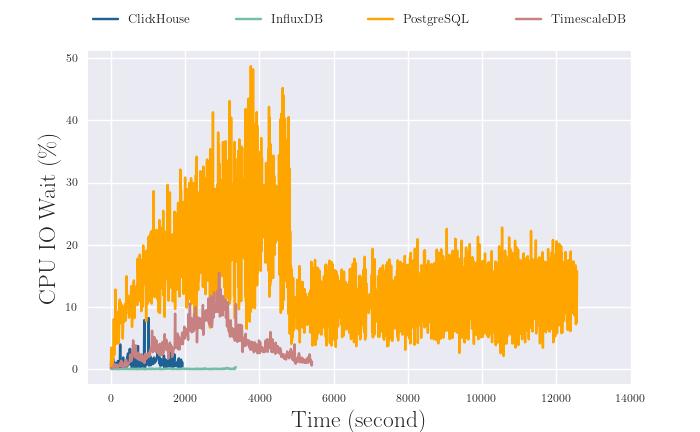

In [345]:
from datetime import datetime as dt
import math
t0 = dt.now()
sysdf= pd.read_csv('../Results/Scaling 48c-20000b-100000s/Glances.csv',)
sysdf['Timestamp'] = pd.to_datetime(sysdf['Timestamp'], unit='ns')
# sysdf.set_index('Timestamp', inplace=True)
sysdf = sysdf.sort_values(by=['Database', 'Timestamp'])
t1 = dt.now()
print('Loaded', len(sysdf), 'Items in', t1-t0)
print(sysdf.columns)
sysgrouped = sysdf.groupby(['Database'])#.filter(lambda x: (x['Database'].iloc[0] == 'PostgresDB') or (x['Database'].iloc[0] == 'TimescaleDB')).groupby(['Database'])

system = {'CpuIOWait': None, 
          'DiskReadBytes': 'log',
         }

# iterator = iter(system.keys())
# plots_len = math.ceil(len(system) / 2)
# fig, ax = plt.subplots(plots_len, 2, figsize=set_size(800), )
# idx= 0
# a = {}
# for metric in iterator:
#     axis = ax[idx] if plots_len == 1 else ax[idx, 0]
#     for key, grp in sysgrouped:
#         data = grp[metric]
#         line = plot_database(axis, data, key, system[metric])
#         a[key] = line[0]
#     axis.set_title(metric)
    
#     try:
#         axis = ax[idx] if plots_len == 1 else ax[idx, 1]
#         metric = next(iterator)
#         for key, grp in sysgrouped:
#             data = grp[metric]
#             plot_database(axis, data, key, system[metric])
#         axis.set_title(metric)
#     except StopIteration as e:
#         pass
#     idx += 1

# fig.legend(list(a.values()), list(a.keys()), loc='upper center', **legend_kwargs)
# fig.tight_layout()
# fig.subplots_adjust(top=0.95)

fig, ax = plt.subplots(1, 1, figsize=set_size('acm'), )


for key, grp in sysgrouped:
    print(key, grp['CpuIOWait'].max(), grp['CpuIOWait'].mean())
    data = grp['CpuIOWait'].groupby(grp['CpuIOWait'].index // 10).mean()
    plot_database(ax, data, key, None,label=labels[key])

ax.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0., prop={'size': 9}) 
# ax.legend(**legend_kwargs)
ax.set_xlabel('Time (second)')
ax.set_ylabel('CPU IO Wait (\%)')
ax.set_xticks(ax.get_xticks()[1:], ax.get_xticks().astype(int)[1:] * 10)
# plt.tight_layout()
plt.show()
plt.savefig('/home/jalal/papers/phd/tsdb/vldb/figures/scaling-cpuiowait.pdf', format='pdf')

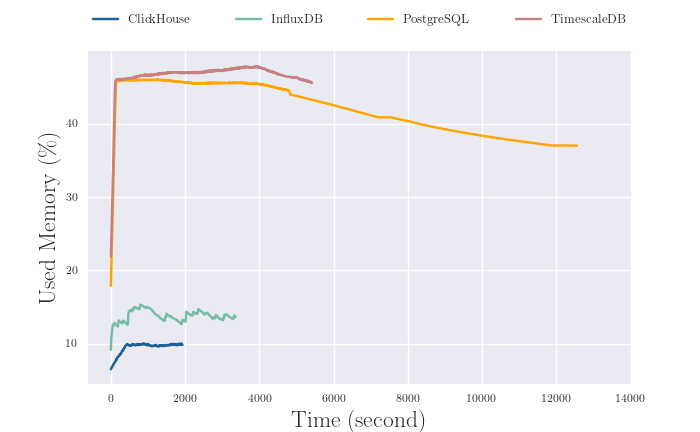

In [348]:
fig, ax = plt.subplots(1, 1, figsize=set_size('acm'), )

metric = 'MemUsed'
print(sysgrouped)
for key, grp in sysgrouped:
    data = grp[metric].groupby(grp[metric].index // 10).mean()
    plot_database(ax, data, key, used_mem, label=labels[key])
ax.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0., prop={'size': 9})
# ax.legend(**legend_kwargs)
ax.set_xlabel('Time (second)')
ax.set_ylabel('Used Memory (\%)')
ax.set_xticks(ax.get_xticks()[1:], ax.get_xticks().astype(int)[1:] * 10)
plt.show()
plt.savefig('/home/jalal/papers/phd/tsdb/vldb/figures/scaling-usedmem.pdf', format='pdf')


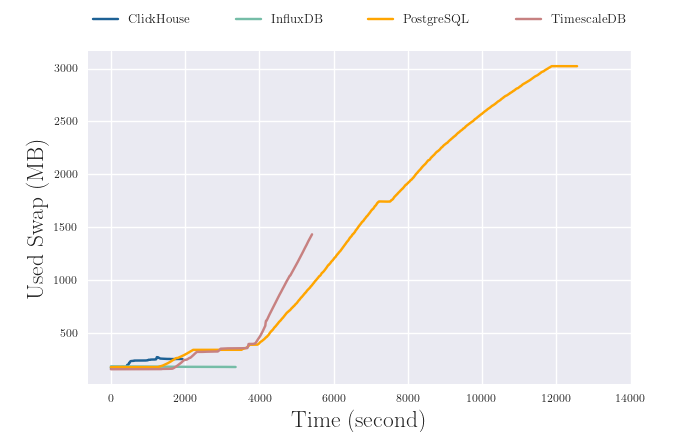

In [349]:
fig, ax = plt.subplots(1, 1, figsize=set_size('acm'), )

metric = 'SwapUsed'
for key, grp in sysgrouped:
    data = grp[metric].groupby(grp[metric].index // 10).mean()
    plot_database(ax, data, key, to_megabytes, label=labels[key])
ax.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0., prop={'size': 9})
# ax.legend(**legend_kwargs)
ax.set_xlabel('Time (second)')
ax.set_ylabel('Used Swap (MB)')
ax.set_xticks(ax.get_xticks()[1:], ax.get_xticks().astype(int)[1:] * 10)
plt.show()
plt.savefig('/home/jalal/papers/phd/tsdb/vldb/figures/scaling-swap.pdf', format='pdf')

## Batching Experiments
Compare the ingesiton performance of the TSDBs and to understand the relationship between the performance and batch size

### Using a single client

#### Batch Latency

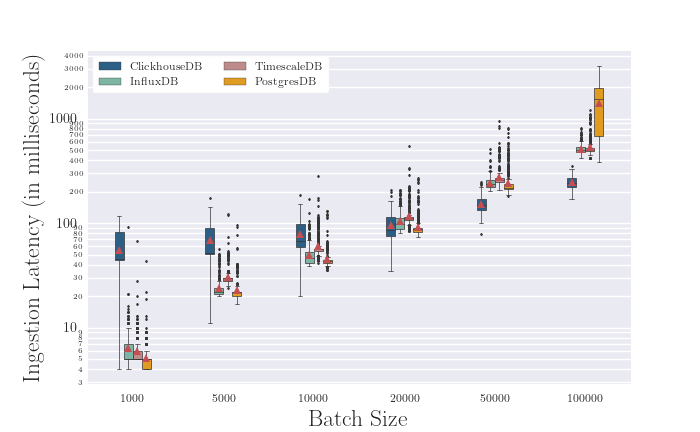

In [295]:
batching_1c = pd.read_csv("../Results/batching/Metrics.csv")
batching_1c['Date'] = pd.to_datetime(batching_1c['Date'], unit='ns')
fig, ax = plt.subplots(figsize=set_size('acm'),)

sns.boxplot(x="BatchSize", y="Latency", hue="TargetDatabase",
            showmeans=True, data=batching_1c, ax=ax, palette=databases, width=0.4, linewidth=0.5,
         fliersize=1,)

ax.set_yscale('log')

ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%d"))
ax.legend(**legend_kwargs)
ax.set_xlabel('Batch Size')
ax.set_ylabel('Ingestion Latency (in milliseconds)')
ax.tick_params(axis='y', which='major', labelsize=10)
ax.tick_params(axis='y', which='minor', labelsize=5)
ax.grid(True, which="both", axis='y')
# fig.tight_layout()
plt.show()
plt.savefig('/home/jalal/papers/phd/tsdb/vldb/figures/batching.pdf', format='pdf')

### Batch Size = 20,000 and Numerous Clients

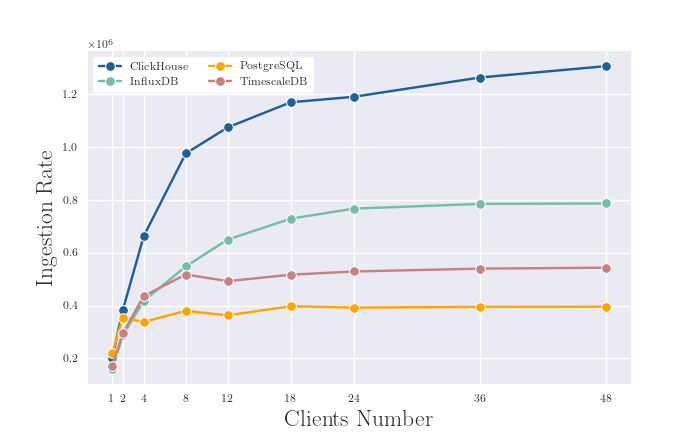

In [284]:
batching_n = pd.read_csv("../Results/batchingN/Metrics2.csv")
batching_n['Date'] = pd.to_datetime(batching_n['Date'], unit='ns')
fig, ax = plt.subplots(figsize=set_size('acm'),)

# sns.boxplot(x="SucceededDataPoints", y="Latency", hue="TargetDatabase",
#             showmeans=True, data=batching_1c, ax=ax, palette=databases,width=0.4,
#             color=color, fliersize=1,)
def batch_ingestionrate(x):
    duration = x['Date'].max() - x['Date'].min()
    sum = x['SucceededDataPoints'].sum()
    return pd.Series({'IngestionRate': sum / duration.total_seconds()})

batchn = batching_n.groupby(['TargetDatabase', 'ClientsNumber']).apply(batch_ingestionrate).reset_index()
sns.lineplot(x='ClientsNumber', y='IngestionRate', hue='TargetDatabase', palette=databases, data=batchn, ax=ax, marker='o')
ax.legend(**legend_kwargs, labels=list(labels.values()))

ax.set_xticks([1,2,4,8,12,18,24,36,48])
ax.set_xlabel('Clients Number')
ax.set_ylabel('Ingestion Rate')

# fig.tight_layout()
plt.show()
plt.savefig('/home/jalal/papers/phd/tsdb/vldb/figures/clients.pdf', format='pdf')

### System Metrics

Loaded 6845 Items in 0:00:00.034794
<a list of 8 Line2D objects>


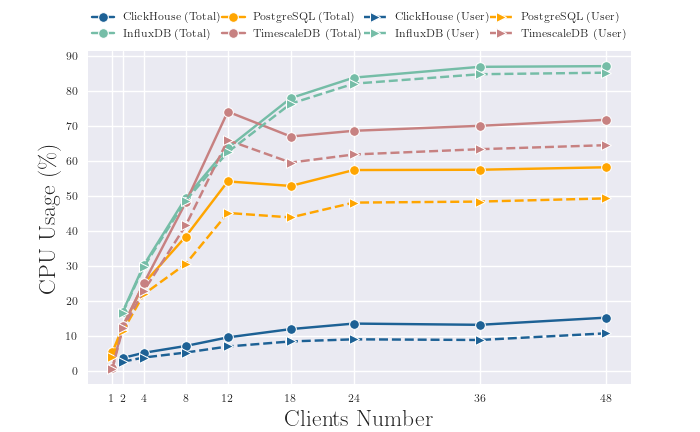

In [444]:
from datetime import datetime as dt
import math
t0 = dt.now()
n_sysdf = pd.read_csv('../Results/batchingN/Glances.csv',)
n_sysdf['Database'] = n_sysdf['Database'].apply(lambda x: labels[x])
n_sysdf['Timestamp'] = pd.to_datetime(n_sysdf['Timestamp'], unit='ns')
# sysdf.set_index('Timestamp', inplace=True)
# sysdf = sysdf.sort_values(by=['Database', 'Timestamp'])
t1 = dt.now()
print('Loaded', len(n_sysdf), 'Items in', t1-t0)

system = {'CpuTotal': None, 'CpuIOWait': None, 
          'CpuSystem': None, 'CpuUser': None,
          'SwapSin': to_megabytes, 'SwapSout': to_megabytes, 'DiskWriteBytes': 'log',
          'DiskReadBytes': 'log', 'DiskWriteCount': 'log', 'DiskReadCount': 'log', 
          'MemAvailable': used_mem, 'MemCached': to_megabytes,
          'SwapUsed': to_megabytes, 'NetworkTransmissions': to_mbps, 'NetworkReceives': to_mbps,
         }



sysgrouped = sysdf.groupby(['Database', 'ClientsNumber'], as_index=False).mean()
# a = {}
# idx = 0
# iterator = iter(system.items())
# for metric, func in iterator:
#     for key, group in sysgrouped.groupby('Database', as_index=False):
#         data = group[metric]
#         line = plot_database(ax[idx, 0], data, key, func, x=group['ClientsNumber'])
#         a[key] = line[0]
#     # sns.lineplot(ax=ax[idx, 0], data=sysgrouped, x='ClientsNumber', y=metric, hue='Database')
#     ax[idx, 0].set_title(metric)
#     ax[idx, 0].set_xticks([1,2,4,8,12,18,24,36,48])
#     try:
#         metric, func = next(iterator)
#         for key, group in sysgrouped.groupby('Database', as_index=False):
#             data = group[metric]
#             line = plot_database(ax[idx, 1], data, key, func, x=group['ClientsNumber'])
        
#         ax[idx, 1].set_title(metric)
#         ax[idx, 1].set_xticks([1,2,4,8,12,18,24,36,48])
#     except StopIteration as e:
#         pass
#     idx += 1


# fig.legend(list(a.values()), list(a.keys()), loc='upper center', **legend_kwargs)
# fig.tight_layout()
# fig.subplots_adjust(top=0.95)

# plt.show()
means = n_sysdf.groupby(['Database', 'ClientsNumber']).mean().reset_index()
fig, ax = plt.subplots(1, 1, figsize=set_size('acm'), )
sns.lineplot(x='ClientsNumber', y='CpuTotal', hue='Database', palette=databases, data=means, ax=ax, marker='o', legend=False)
sns.lineplot(x='ClientsNumber', y='CpuUser', hue='Database', palette=databases, data=means, ax=ax,  marker='>', linestyle="dashed", legend=False)
ax.set_xticks([1, 2, 4, 8, 12, 18, 24, 36, 48])
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
ax.set_xlabel('Clients Number')
ax.set_ylabel('CPU Usage (\%)')
print(ax.get_lines())
h, l = ax.get_legend_handles_labels()
handles = []
lbls = []
# for x in range(len(h)):
#     if l[x] in labels.values():
#         handles.append(h[x])
#         lbls.append(l[x])
# [x for x in ax.get_lines() if x.get_label() in labels.values()], ['ClickHouse (Total)', 'InfluxDB (Total)', 'PostgreSQL (Total)',  'TimescaleDB (Total)', 'ClickHouse (User)', 'InfluxDB(User)', 'PostgreSQL(User)',  'TimescaleDB(User)',], 
ax.legend(labels=['ClickHouse (Total)', 'InfluxDB (Total)', 'PostgreSQL (Total)',  'TimescaleDB (Total)', 'ClickHouse (User)', 'InfluxDB (User)', 'PostgreSQL (User)',  'TimescaleDB (User)',],
         bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0., prop={'size': 8})
plt.show()
plt.savefig('/home/jalal/papers/phd/tsdb/vldb/figures/clients-cpu.pdf', format='pdf')

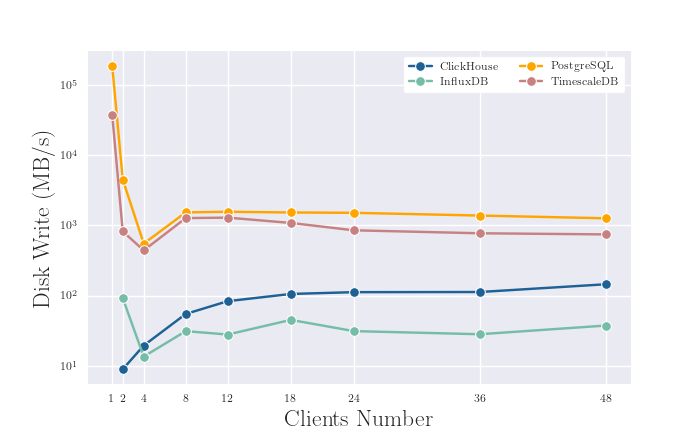

In [456]:
means = n_sysdf.groupby(['Database', 'ClientsNumber']).mean().reset_index() 
means['DiskWriteBytes'] = means['DiskWriteBytes'] / 1e6
fig, ax = plt.subplots(1, 1, figsize=set_size('acm'), )

sns.lineplot(x='ClientsNumber', y='DiskWriteBytes', hue='Database', palette=databases, data=means, marker='o', legend=False,
             ax=ax, markers='o', 
            )
ax.set_yscale('log')
ax.set_xticks([1, 2, 4, 8, 12, 18, 24, 36, 48])
# ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
ax.set_xlabel('Clients Number')
ax.set_ylabel('Disk Write (MB/s)')
ax.legend(labels=['ClickHouse', 'InfluxDB', 'PostgreSQL',  'TimescaleDB'], **legend_kwargs, )
plt.show()
plt.savefig('/home/jalal/papers/phd/tsdb/vldb/figures/clients-diskwrite.pdf', format='pdf')

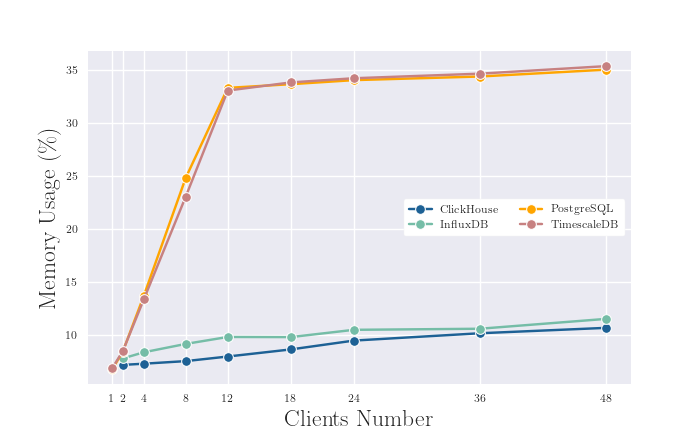

In [449]:
means = n_sysdf.groupby(['Database', 'ClientsNumber']).mean().reset_index()
means['MemUsed'] = used_mem(means['MemUsed'])
fig, ax = plt.subplots(1, 1, figsize=set_size('acm'), )

sns.lineplot(x='ClientsNumber', y='MemUsed', hue='Database', palette=databases, data=means, marker='o',
             ax=ax, markers='o'
            )
ax.set_xticks([1,2,4,8,12,18,24,36,48])
# ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
ax.set_xlabel('Clients Number')
ax.set_ylabel('Memory Usage (\%)')
ax.legend(labels=['ClickHouse', 'InfluxDB', 'PostgreSQL',  'TimescaleDB'], **legend_kwargs, loc='center right')
plt.show()
plt.savefig('/home/jalal/papers/phd/tsdb/vldb/figures/clients-mem.pdf', format='pdf')

# Queries

In [480]:
queries_results = pd.read_csv('../Results/queries/Metrics.csv')
def _query_stat(group):
    lat = group['Latency']
    return pd.Series({'min': lat.min(), 'avg': lat.mean(), '95': lat.quantile(0.95), 'max': lat.max(),  'stddev': lat.std()})

def show_query_stat(qtype):
    dbs = queries_results[queries_results['Operation'] == qtype].groupby('TargetDatabase').apply(_query_stat)
    show(dbs)
    


In [481]:
show_query_stat('RangeQueryRawData')

Loading... (need help?)


In [482]:
show_query_stat('OutOfRangeQuery')

Loading... (need help?)


In [483]:
show_query_stat('STDDevQuery')

Loading... (need help?)


In [484]:
show_query_stat('RangeQueryAggData')

Loading... (need help?)


In [485]:
show_query_stat('DifferenceAggQuery')

Loading... (need help?)
